### Motion Optimization for Battery Range Extension
#### Solved by using Reinforcement Learning with Deep Q-Networks

References: 
- https://gymnasium.farama.org/environments/classic_control/mountain_car/
- https://github.com/Bduz/intro_pytorch/tree/main/intro_rl/dqn

In [ ]:
# Cloning my Repository
!git clone https://github.com/dolunay-adastec/Deep_Learning.git
!cd /content/Deep_Learning/DRL_Deep_Reinforcement_Learning/Motion_Optimization_of_an_EV && git checkout main_colab

### 1 - Importing Necessary Libraries

In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,'/content/Deep_Learning/DRL_Deep_Reinforcement_Learning/Motion_Optimization_of_an_EV/')
from collections import deque
import function_library as fl
import Custom_Environment
from IPython.display import clear_output
# sys.path.instert(0,'../')

In [ ]:
print(torch.__version__)
!pip uninstall torch -y
!pip install torch==2.0.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

### 2 - Initialize the Environment and the Agent

In [2]:
# Instantiating the environment and the agent
env = Custom_Environment.CustomEnv()
print('State shape: ', env.observation_space.shape)     # 12 states
print('Number of actions: ', env.action_space.n)        # 21 actions

State shape:  (12,)
Number of actions:  21


#### 2.1 - Watching an untrained agent

Total Reward:  -501.76821551872774
Total Time Reward:  -358.86515290075636
Total Energy Reward:  -21.903062617971425
Total Position Reward:  -121.0


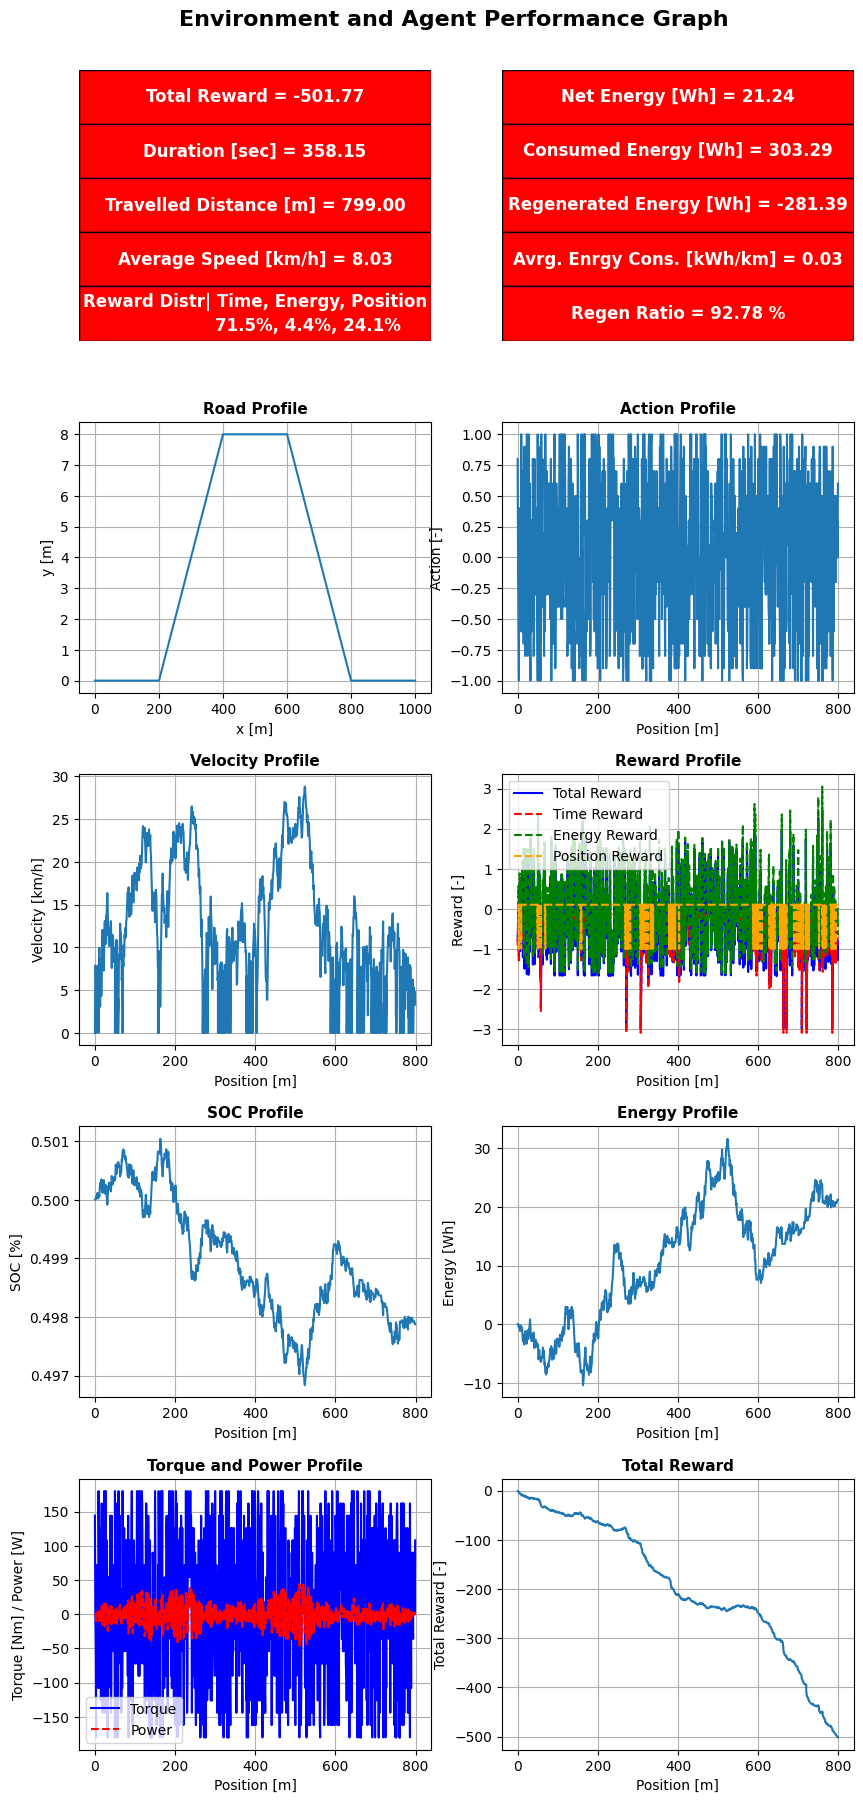

c:\Repositories\Personal_Repositories\Deep_Learning\DRL_Deep_Reinforcement_Learning\Motion_Optimization_of_an_Electric_Vehicle_for_Range_Extension\Simulation Outputs - 2023-07-13_23-22-54\Episode_1__Score_-501.76821551872774__Date_2023-07-13_23-22-57.png


In [5]:
# Creating a folder to store the results
folder_path = fl.create_folder()
# Creating a database to store the results
columnm = ['Pos','act','x','y','v','a','Duration','Gradient','SOC','Power','Energy','F_load','F_traction','Wind','dt','Brake','Throttle','Power','Torque','dt_Energy_wh','Total_Reward','dt_Time_reward','dt_Energy_reward','dt_Position_reward']
database = pd.DataFrame(columns=columnm)

# Instantiating the agent
episode_number = 1
state = env.reset()
for i in range(1001):
    #________ Random Action __________#
    # Create an array of 21 numbers ranging from -1 to 1 with increment of 0.1
    numbers = np.linspace(-1, 1, 21)
    # Select a random number from the array
    random_number = np.random.choice(numbers)
    # Format the number to display up to 1 decimal point
    action = "{:.1f}".format(random_number)
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break
    database.loc[i] = np.concatenate([env.current_state, env.debug_values])
Score, plot = fl.grapher(env, database, show_fig = True)
fl.save_outputs(folder_path, database, episode_number, Score)
clear_output(wait=True)


### 3 - Train the Agent with DQN

In [ ]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
from collections import deque
from IPython.display import clear_output
import datetime
import os
import sys
sys.path.insert(0,'/content/Deep_Learning/DRL_Deep_Reinforcement_Learning/DRL_DQN/DQN_Mountain_Car/')
import function_library as fl
import Custom_Environment
# Import the Agent
from DRL_DQN_Agent import DQN_Agent
# Instantiating the agent
agent = DQN_Agent(state_size=14, action_size=21, seed=0)    # 14 states, 21 actions. The seed is set to 0 to get the same results every time
# Actions are in the range of -1 to 1 with increment of 0.1 which represents the throttle and brake. if the action is 0, it means no throttle or brake, if the action is 1, it means full throttle, if the action is -1, it means full brake.
# Load the weights from file (if available) 500 episodes, no wind disturbance and 256 layers simulation
checkpoint = torch.load('C:\Repositories\Personal_Repositories\Deep_Learning\DRL_Deep_Reinforcement_Learning\Motion_Optimization_of_an_EV\Simulation_Outputs\Simulation_Outputs__2023-07-17_07-57-20__Solved_278__Wind_Disturbance\checkpoint.pth')
agent.qnetwork_local.load_state_dict(checkpoint['model_state_dict'])
agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# Print if the weights are loaded
print('Weights Loaded')
# Creating a folder to store the results
folder_path = fl.create_folder()
def save_outputs(folder_path, database, episode_number, Score, fig):
    
    # Get the current time
    now = datetime.datetime.now()
    Score = format(Score,".2f")
    # Define the figure name
    simulation_time = now.strftime("%Y-%m-%d_%H-%M-%S")
    fig_name = f"Episode_{episode_number}__Score_{Score}__Date_{simulation_time}.png"
    database_name = f"Episode_{episode_number}_Database_.csv"
    database_name_2 = f"Episode_{episode_number}_Database_.df"
    # Save the figure
    full_path = os.path.join(folder_path, fig_name)
    print(full_path)
    fig.savefig(full_path)
    #plt.savefig(full_path)
    # Save the database to be able to investigate the results
    full_path = os.path.join(folder_path, database_name)
    database.to_csv(full_path, index=False)
    full_path = os.path.join(folder_path, database_name_2)
    database.to_pickle(full_path)
    # Close the figure
    plt.close()

# Training the agent for 500 episodes
# By definend a def function, we can simply the code block at the end of this block.
def dqn(n_episodes=500, max_t=3000, eps_start=1.0, eps_end=0.01, eps_decay=0.95,folder_path=folder_path): # min_t = 1001 due to the road lenght
    """Deep Q-Learning.
    Params
    ======
        n_episodes (int): Maximum number of training episodes. In this case, it is 2000.
        max_t (int): Maximum number of timesteps per episode. In this case, it is 1000.
        eps_start (float): Starting value of epsilon, for epsilon-greedy action selection. In this case, it is 1.
        eps_end (float): Minimum value of epsilon. In this case, it is 0.01.
        eps_decay (float): Multiplicative factor (per episode) for decreasing epsilon. In this case, it is 0.995.
    """
    
    # Creating a database column store the results
    columnm = ['Pos','act','x','y','v','a','Duration','Gradient','SOC','Power','Energy','F_load','F_traction','Wind','dt','Brake','Throttle','Power','Torque','dt_Energy_wh','Total_Reward','dt_Time_reward','dt_Energy_reward','dt_Position_reward']
    
    # Creating a list to store the scores
    scores = []
    # Creating a list to store the scores
    scores_window = deque(maxlen=100)
    # Defining the epsilon value
    eps = eps_start

    # Instantiating the Environment
    env = Custom_Environment.CustomEnv(wind_disturbance_enabled=True)
    env.reset()

    # TODO: Second Vehicle Environment that travelling max speed of 20 m/s
    # Creating a database to store the results
    database_dummy = pd.DataFrame(columns=columnm)
    # Creating the dummy environment
    env_dummy = Custom_Environment.CustomEnv(wind_disturbance_enabled=True)
    env_dummy.reset()
    for i in range(1001):   # Manual Control
        # I am using the following control strategy to get highr score than Action=1 (Full Throttle) 
        if i <= 200:        env_dummy.step(0.2)
        elif i <= 400:      env_dummy.step(0.2)
        elif i <= 600:      env_dummy.step(0.1)
        elif i <= 650:      env_dummy.step(-0.1)
        elif i <= 700:      env_dummy.step(0)
        elif i <= 750:      env_dummy.step(-0.1)
        elif i <= 800:      env_dummy.step(0)
        elif i <= 850:      env_dummy.step(0.1)
        elif i <= 900:      env_dummy.step(0.2)
        elif i <= 975:      env_dummy.step(0.1)
        else:               env_dummy.step(-0.1)
        # Saving the results to the database
        database_dummy.loc[i] = np.concatenate([env_dummy.current_state, env_dummy.debug_values])
    # Storing the last state of the dummy environment
    database_dummy.loc[i] = np.concatenate([env_dummy.next_state, env_dummy.debug_values])
    
    # Iterating over the number of episodes
    #for i_episode in range(1, n_episodes+1):
    for i_episode in range(1, n_episodes+1):
        # Creating/resetting a database to store the results
        database = pd.DataFrame(columns=columnm)
        # Resetting the environment
        state = env.reset()
        # Resetting the score
        score = 0
        # Iterating over the number of timesteps
        for t in range(max_t):
            # Selecting an action
            action = agent.act(state, eps)
            action_real = (action-10)/10
            # Taking a step
            next_state, reward, done, _ = env.step(action_real)
            # Storing the experience
            agent.step(state, action, reward, next_state, done)
            # Updating the state
            state = next_state
            # Updating the score
            score += reward
            # Storing the results
            database.loc[t] = np.concatenate([env.current_state, env.debug_values])
            # Checking if the episode is done
            if done:
                break
        database.loc[t] = np.concatenate([env.next_state, env.debug_values])
        # Appending the score to the scores list
        scores_window.append(score)
        # Appending the score to the scores list
        scores.append(score)
        # Decreasing the epsilon value
        eps = max(eps_end, eps_decay*eps)
        # Printing the results
        print('\rEpisode {}\tAverage Score: {:.2f}\n'.format(i_episode, np.mean(scores_window)), end="")
        # Printing the results
        _, plot, fig = fl.grapher(env, database, database_dummy, show_fig=True)
        # Saving the results
        save_outputs(folder_path, database, i_episode, score, fig)
        # Clearing the output
        clear_output(wait=True)
        if np.mean(scores_window)>=50:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}\n'.format(i_episode, np.mean(scores_window)))
            # Save the weights
            #torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores, database

# Training the agent
scores, database = dqn()
# Saving the weights and optimizer parameters of the agent to use it later for testing the agent
torch.save({'model_state_dict': agent.qnetwork_local.state_dict(),'optimizer_state_dict': agent.optimizer.state_dict(),}, folder_path + '/checkpoint.pth')
# Plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Training Results of DQN Agent')
plt.savefig(folder_path + '/Score.png')
plt.show()
